Created by Michal Bukowski (michal.bukowski@tuta.io, m.bukowski@uj.edu.pl) under GPL-3.0 license as a part of the [dge-ontology](https://github.com/michalbukowski/dge-ontology) repository<br>
Department of Analytical Biochemistry, Biophysics and Biotechnology, Jagiellonian University, Krakow, Poland

---
# Basic examples of `dgeontology` library usage
This Jupyter notebook demonstrates an approach to ontology analysis (GSEA, gen set enrichment analysis) and visualisation performed for DGE (differential gene expression) results that were obtained using [Salmon](https://doi.org/10.1186/s13059-014-0550-8) and [DESeq2](https://doi.org/10.1038/nmeth.4197). However, the approach can be used for any kind of differential analysis (e.g. in proteomics). Execution of subsequent cells in many instances relies on the output of preceding cells, thus <u>cells should be executed in the order as presented in this notebook</u>.

<u>Notebook cell output has been saved in the original (repository) version of the notebook</u>. If rerun for the exemplary data, it should give the same results. All visualisations are saved to `output` directory as high-resolution PNG files.

This example uses input that contains metadata on _Staphylococcus aureus_ RN4220 transcriptome and output from [rnaseq-pipeline-2](https://github.com/michalbukowski/rnaseq-pipeline-2) executed for two strains sampled in the logarithmic growth phase: a wild type (`wt51e`) vs. $\Delta$_saoBC_ mutant (`mt51e`) (NCBI BioProject accession number PRJNA798259).

It shows two important aspects of using the `dgeontology` library. These are:
- how to use the `dgeontology` library in the most basic way, and subsequently how to modify default values of the `dgeont_plot()` function arguments in order to achieve a desirable outcome
- how to access and handle the analysis output results and the output figure

---
## Environment setup
As the first step, necessary imports and environment setup are performed.

In [1]:
# Import Pandas library for the input data handling and PIL
# for optional removal of the alpha channel the final figure.
import pandas as pd
from PIL import Image

# Import the dgeont_plot() function from the dgeontology library
# for rendering DGE/GSEA pie charts.
from dgeontology import dgeont_plot

# Configure the environments to make sure the way figures
# are displayed in the notebook is the same as they are saved.
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

# Attempt to create a directory for output files,
# in case it does not exist.
! mkdir -p output

---
## Loading the input data
The input data is read into Pandas DataFrames. The crucial aspect here is to set each DataFrame index to <u>a column that holds IDs of the analysed entities </u> (e.g. transcripts). For demonstration purposes, purely optionally, the content of the resulting DataFrames is inspected.

In [2]:
# Load DGE results for a complete population,
# i.e. even for those entities (genes, proteins)
# that could be present in the sample (bacterial transcriptome,
# proteome, etc.) but were not (e.g. non-transcribed genes).
# In this example two groups were compared:
# wt51e_lg - wild type, mt51e_lg - mutant.
# Importantly, the column that contains IDs of analysed
# entities is set to be the DataFrame index.
dge_df = pd.read_csv(
    'input/mt51e_wt51e_DGE.tsv',
    index_col = 'locus_tag',
    sep = '\t'
)
display(dge_df.info())
dge_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3335 entries, SAOUHSC_03055 to srn_1040_sRNA92
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   baseMean        2503 non-null   float64
 1   log2FoldChange  2503 non-null   float64
 2   lfcSE           2503 non-null   float64
 3   pvalue          2496 non-null   float64
 4   padj            2496 non-null   float64
dtypes: float64(5)
memory usage: 156.3+ KB


None

,baseMean,log2FoldChange,lfcSE,pvalue,padj
locus_tag,,,,,
SAOUHSC_03055,900.082113,-0.190838,0.253922,0.107434,0.681069
SAOUHSC_03054,12.453537,-0.023077,0.201086,0.677658,0.943881
SAOUHSC_03053,167.816277,0.057208,0.196688,0.491597,0.892770
SAOUHSC_03051,223.827558,0.025922,0.177333,0.784860,0.962877
SAOUHSC_03049,479.204817,-0.012935,0.165215,0.895382,0.981500


In [3]:
# Load metadata for all entities (genes, transcripts, proteins, etc.).
# Importantly, the column that contains IDs of analysed
# entities is set to be the DataFrame index.
meta_df = pd.read_csv(
    'input/rn.tsv',
    index_col = 'locus_tag',
    sep = '\t'
)
display(meta_df.info())
meta_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3466 entries, SAOUHSC_00001 to srn_5130_Sau6728
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   type             3466 non-null   object
 1   pan_gene_symbol  1522 non-null   object
 2   product          3457 non-null   object
 3   vfdbont          136 non-null    object
 4   cog              1774 non-null   object
dtypes: object(5)
memory usage: 162.5+ KB


None

,type,pan_gene_symbol,product,vfdbont,cog
locus_tag,,,,,
SAOUHSC_00001,CDS,dnaA,chromosomal replication initiation protein,NaN,"Replication, recombination and repair"
SAOUHSC_00002,CDS,dnaN,DNA polymerase III subunit beta,NaN,"Replication, recombination and repair"
SAOUHSC_00003,CDS,NaN,hypothetical protein,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_00004,CDS,recF,recombination protein F,NaN,"Replication, recombination and repair"
SAOUHSC_00005,CDS,gyrB,DNA gyrase subunit B,NaN,"Replication, recombination and repair"


---
## Plot 1
Render the DGE-ontology pie chart at default values of the `dgeont_plot()` function arguments. The function requires 7 obligatory arguments.

2 positional arguments:
- `dge_df` &ndash; Pandas DataFrame containing DGE results. The DataFrame must be index with analysed entities IDs (e.g. transcript IDs).
- `meta_df` &ndash; Pandas DataFrame linking IDs to ontology labels. The DataFrame must also be index with analysed entities IDs.

5 keyword arguments:
- `fold_col` &ndash; the name of the column in `dge_df` that contains fold change values, a string value.
- `pval_col` &ndash; the name of the column in `dge_df` that contains FDR values, a string value.
- `onts_col` &ndash; the name of the column in `meta_df` that contains ontology labels, a string value.
- `fold_th` &ndash; a minimal threshold value for `fold_col` (fold change) absolute values used for filtering the results `dge_df`, a float value.
- `fdr_th` &ndash; a maximal threshold value for `pval_col` (FDR) used for filtering the results in `dge_df`, a float value.

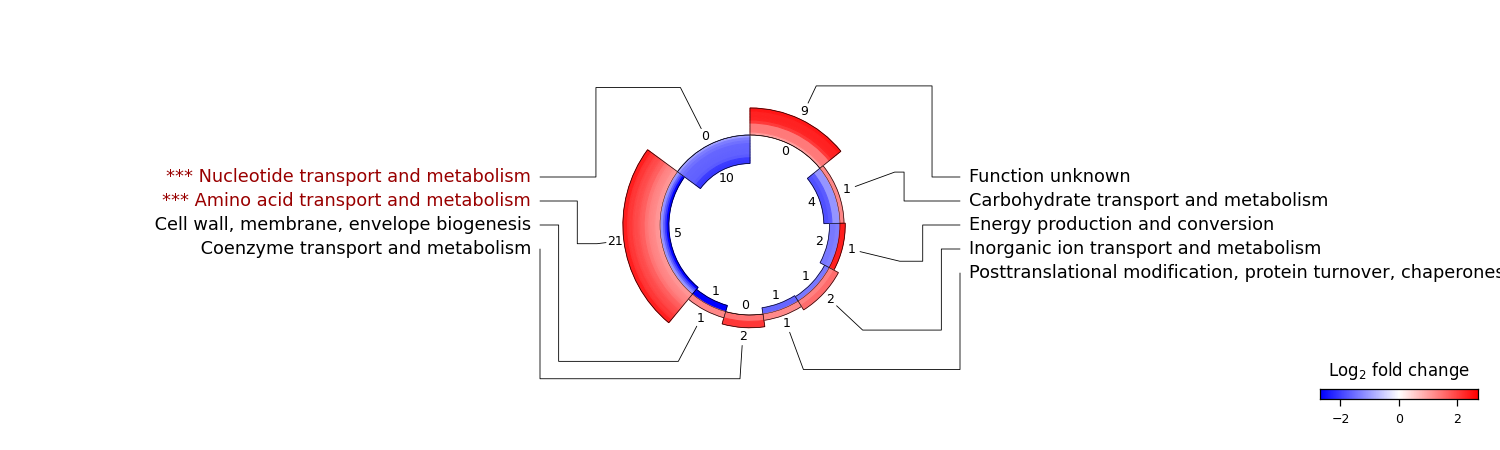

In [4]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_df, meta_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=1.0, fdr_th=0.05,
)

---
## Plot 2
Render the plot once again and change the default values for 3 optional arguments that will help to better position the pie chart in the figure and to avoid white spaces around it.

Optional keyword arguments used in this example that allow to modify the formatting of the final pie chart figure and axes:
- `fig_h` &ndash; Matplotlib Figure height in inches, a float value. Default value: `3.0`.
- `xmin` &ndash; the lower limit value for the X axis, a float value. Default value: `-2.5`.
- `xmax` &ndash; the upper limit value for the X axis, a float value. Default value: `2.5`.

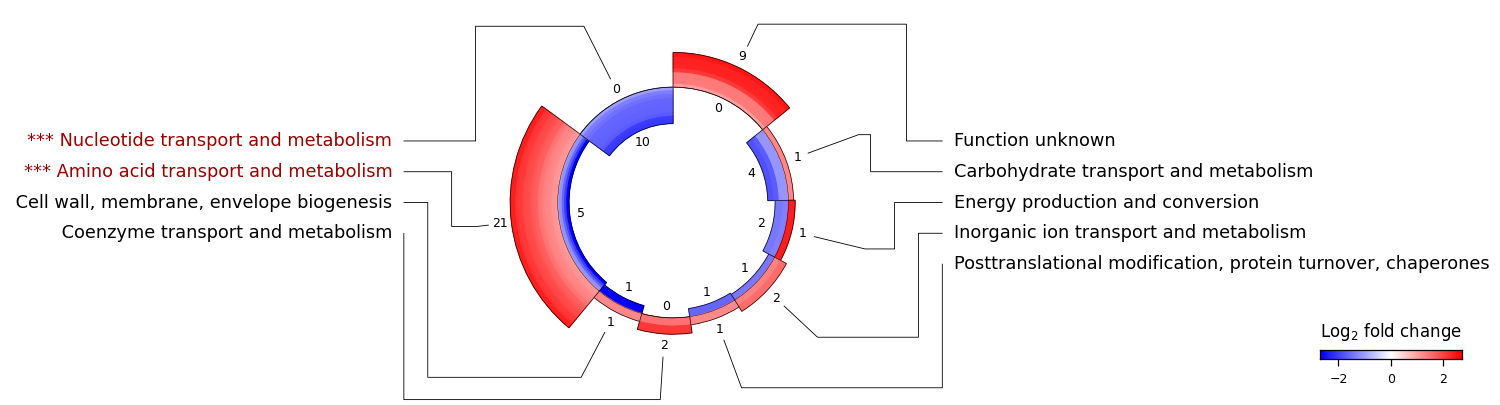

In [5]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_df, meta_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=1.0, fdr_th=0.05,
    fig_h=2.7, xmin=-1.75, xmax=2.15
)

---
## Plot 3
Render the plot once again and change the default value for another optional argument that controls the pie chart radius. Adjust the already used ones to position the chart within the figure.

The optional keyword argument used additionally in this example that allows to modify the pie chart radius:
- `pie_r` &ndash; the radius of the pie chart scaffold circle, a float value. Default value: `0.30`. 

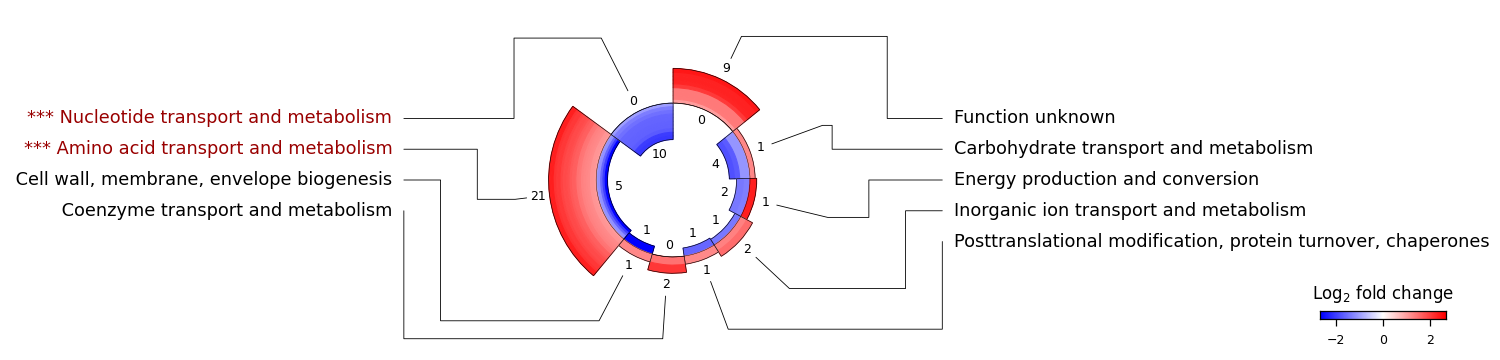

In [6]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_df, meta_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=1.0, fdr_th=0.05,
    pie_r=0.2, fig_h=2.4, xmin=-1.75, xmax=2.15
)

---
## Plot 4
Render the plot once again and change the default value for another optional argument that controls the size of the pie chart wedges (slices). Adjust the already used ones to position the chart within the figure.

The optional keyword argument used additionally in this example that allows to modify the size of pie chart wedges:
- `scale` &ndash; general scale factor, a float value. Change to increase or decrease the relative wedge radial sizes, especially if inner parts pass through the middle of the chart. Default value: `0.03`.

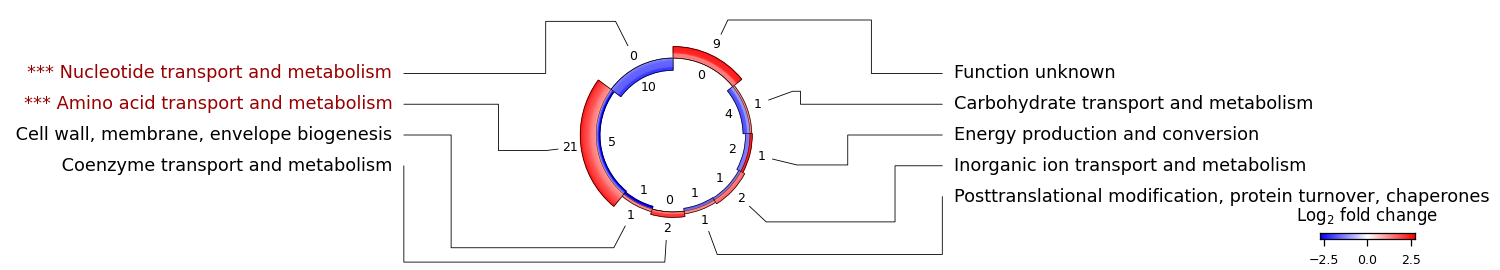

In [7]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_df, meta_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=1.0, fdr_th=0.05,
    scale=0.01, pie_r=0.2, fig_h=1.8, xmin=-1.75, xmax=2.15
)

---
## Plot 5
Render a similar plot to the Plot 4. However, instead of decreasing, increase the size of the pie chart wedges. Adjust the already used ones to position the chart within the figure.

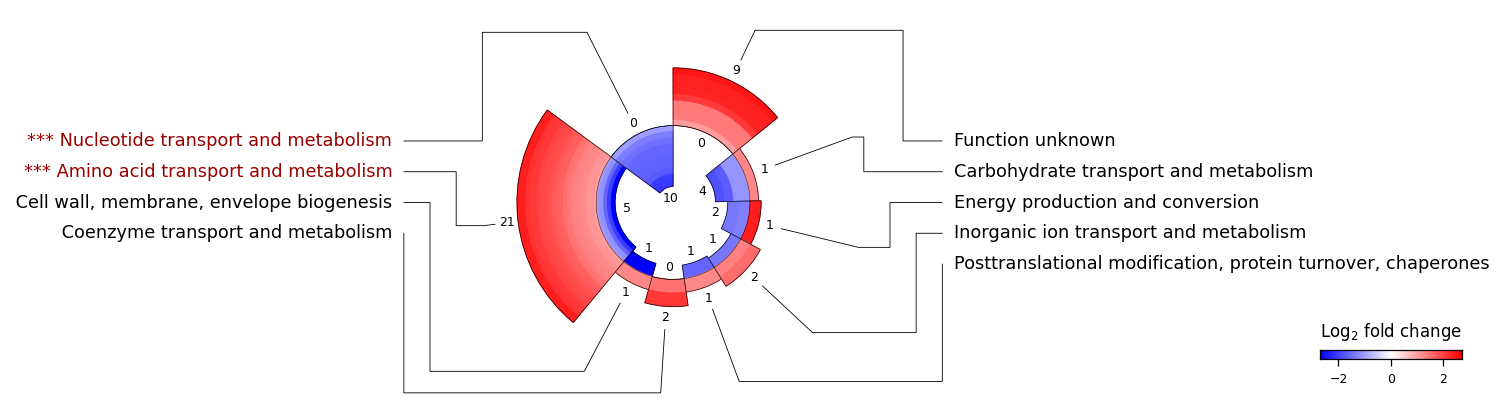

In [8]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_df, meta_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=1.0, fdr_th=0.05,
    scale=0.05, pie_r=0.2, fig_h=2.7, xmin=-1.75, xmax=2.15
)

---
## Plot 6
Render the plot once again and change the default value for another optional argument that controls the fold change scale range. Adjust the already used ones to position the chart within the figure.

The optional keyword argument used additionally in this example that allows to modify the fold change scale range:
- `max_fold` &ndash; the maximum fold change value for the fold scale, a float value. If None, it is set automatically to the highest absolute fold value. Set it manually if you want to generate charts that depict results in a fixed scale. Default value: `None` (automatic scale).

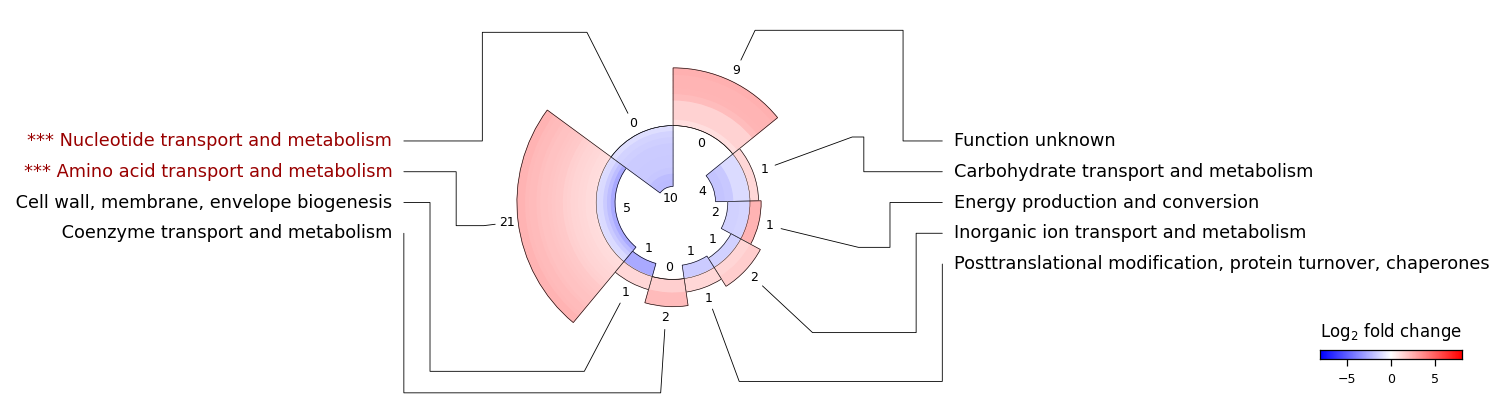

In [9]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_df, meta_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=1.0, fdr_th=0.05,
    max_fold=8, scale=0.05, pie_r=0.2, fig_h=2.7, xmin=-1.75, xmax=2.15
)

---
## Inspecting the analysis results returned by `dgeont_plot()` function
- Inspect the content of the final DataFrame `fin_df`, which is a product of a merge of `dge_df` and ontology columns from `meta_df` on both DataFrames index values.

In [10]:
print(fin_df.info())
fin_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3335 entries, SAOUHSC_03055 to srn_1040_sRNA92
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   baseMean         2503 non-null   float64
 1   log2FoldChange   2503 non-null   float64
 2   lfcSE            2503 non-null   float64
 3   pvalue           2496 non-null   float64
 4   padj             2496 non-null   float64
 5   type             3335 non-null   object 
 6   pan_gene_symbol  1487 non-null   object 
 7   product          3326 non-null   object 
 8   vfdbont          135 non-null    object 
 9   cog              1773 non-null   object 
dtypes: float64(5), object(5)
memory usage: 415.6+ KB
None


,baseMean,log2FoldChange,lfcSE,pvalue,padj,type,pan_gene_symbol,product,vfdbont,cog
locus_tag,,,,,,,,,,
SAOUHSC_03055,900.082113,-0.190838,0.253922,0.107434,0.681069,CDS,rpmH,50S ribosomal protein L34,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03054,12.453537,-0.023077,0.201086,0.677658,0.943881,CDS,rnpA,ribonuclease P,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03053,167.816277,0.057208,0.196688,0.491597,0.892770,CDS,trmE,tRNA modification GTPase TrmE,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03051,223.827558,0.025922,0.177333,0.784860,0.962877,CDS,gidB,16S rRNA methyltransferase GidB,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03049,479.204817,-0.012935,0.165215,0.895382,0.981500,CDS,noc,hypothetical protein,NaN,"Cell cycle control, cell division, chromosome ..."


- Inspect the content of the DataFrame `filt_df`, which is a filtered `fin_df` with respect to the threshold values of `fold_th` and `fdr_th`.

In [11]:
print(filt_df.info())
filt_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, SAOUHSC_03025 to SAOUHSC_01818
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   baseMean         54 non-null     float64
 1   log2FoldChange   54 non-null     float64
 2   lfcSE            54 non-null     float64
 3   pvalue           54 non-null     float64
 4   padj             54 non-null     float64
 5   type             54 non-null     object 
 6   pan_gene_symbol  52 non-null     object 
 7   product          54 non-null     object 
 8   vfdbont          7 non-null      object 
 9   cog              45 non-null     object 
dtypes: float64(5), object(5)
memory usage: 4.6+ KB
None


,baseMean,log2FoldChange,lfcSE,pvalue,padj,type,pan_gene_symbol,product,vfdbont,cog
locus_tag,,,,,,,,,,
SAOUHSC_03025,65.012526,1.248228,0.402613,8.729000e-05,0.005067,CDS,pcp,pyrrolidone-carboxylate peptidase,NaN,"Posttranslational modification, protein turnov..."
SAOUHSC_03013,24.618089,1.269422,0.587313,1.111299e-03,0.038525,CDS,hisD,histidinol dehydrogenase,NaN,Amino acid transport and metabolism
SAOUHSC_03010,12.871730,2.384308,0.899698,3.365842e-04,0.015851,CDS,hisH,imidazole glycerol phosphate synthase subunit ...,NaN,Amino acid transport and metabolism
SAOUHSC_02706,421.621567,2.348295,0.470815,2.628841e-08,0.000007,CDS,sbi,immunoglobulin G-binding protein Sbi,Sbi,NaN
SAOUHSC_02681,65.388397,-1.432015,0.331830,7.925336e-07,0.000110,CDS,narG,nitrate reductase subunit alpha,NaN,Energy production and conversion; Inorganic io...


- Display some statistics regarding the DGE results contained in the DataFrames `fin_df` and `filt_df`.

In [12]:
# Show general statistics on the differential analysis
# (on raw data and filtered ones).
fold_col = 'log2FoldChange'
print('Rows are understood as results/cases related to given entities')
print('Total rows:', fin_df.shape[0])
print('Non-empty (quantified) rows:', fin_df[fold_col].notna().sum())
print('Rows that passed filtering (differentiating):', filt_df.shape[0])
print('Min. fold: ', fin_df[fold_col].min().round(4))
print('Max. fold: ', fin_df[fold_col].max().round(4))
print('Up:  ', (filt_df[fold_col] > 0.0).sum())
print('Down:', (filt_df[fold_col] < 0.0).sum())

Rows are understood as results/cases related to given entities
Total rows: 3335
Non-empty (quantified) rows: 2503
Rows that passed filtering (differentiating): 54
Min. fold:  -2.7013
Max. fold:  2.4663
Up:   34
Down: 20


- Inspect the GSEA analysis results contained in the DataFrame `ont_df`.

In [13]:
ont_df.head()

,pval,trend,total_size,sample_size,total_cases,sample_cases,downreg_cases,upreg_cases,expected
ont,,,,,,,,,
Function unknown,2.811362e-06,under,3335,54,1562,9,0,9,25
Amino acid transport and metabolism,4.360153e-17,over,3335,54,228,26,5,21,4
"Translation, ribosomal structure and biogenesis",3.053226e-02,under,3335,54,207,0,0,0,3
Inorganic ion transport and metabolism,5.007598e-01,normal,3335,54,164,3,1,2,3
Carbohydrate transport and metabolism,1.146575e-01,normal,3335,54,160,5,4,1,3


---
## Plot 7
Render a pie chart as depicted in the `fig. 1` in the original DGE-ontology publication in SoftwareX (Elsevier) journal. Next to the first 5 obligatory arguments, default values for 4 optional ones are adjusted.

4 optional keyword arguments used in this example:
- `bont_col` &ndash; the column name that contains additional ontology data, a string value. The values of the column are treated as binary (true or false, whether the values are empty/NA or any non-empty value) and described with the label (`bnt_label`). If `bont_col` is not None, `bont_label` is merged with labels provided in `onts_col`. Default value: `None` (no binary ontology column is provided).
- `bont_label` &ndash; If `bont_col` is not None, `bont_label` <u>must be set</u> to a string value that will be treated as ontology label for any non-empty with respect to `bont_col` row. Default value: `None` (no binary ontology column is provided).
- `xmin` &ndash; the lower limit value for the X axis, a float value. Default value: `-2.5`.
- `xmax` &ndash; the upper limit value for the X axis, a float value. Default value: `2.5`.

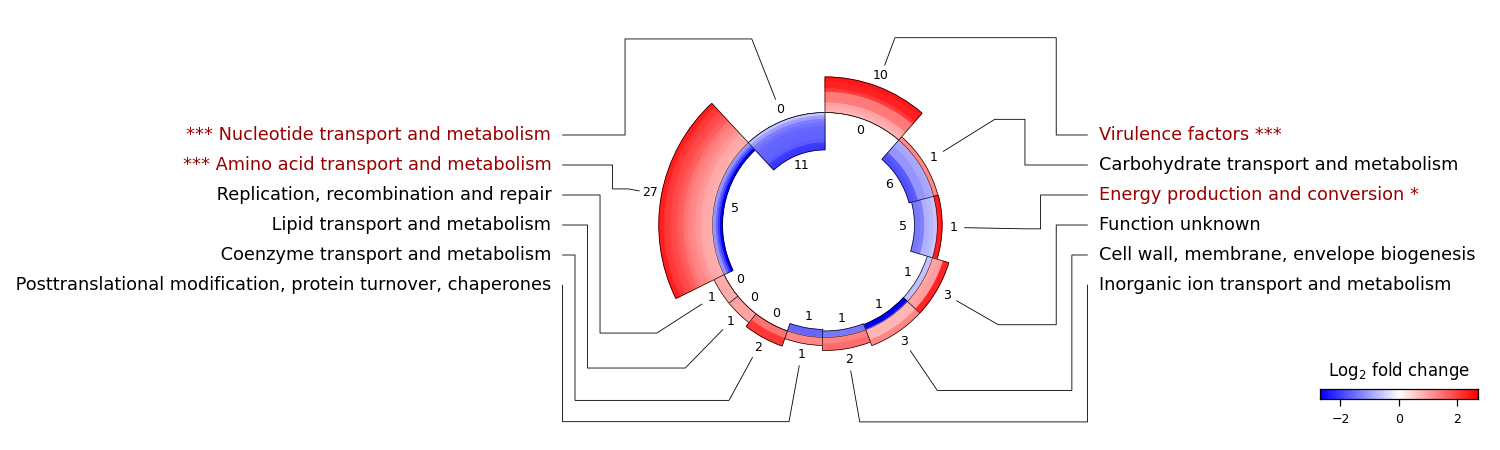

In [14]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_df, meta_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=0.58, fdr_th=0.05,
    bont_col='vfdbont', bont_label='Virulence factors', xmin=-2.2, xmax=1.8
)

---
## Saving a DGE-ontology pie chart to a file
The `dgeont_plot()` function returns, among all, the reference to a Matplotlib Figure in which the pie chart was rendered. Thanks to it, the figure may be further processed and modified as any Matplotlib Figure. Here, the figure is saved to a PNG file with non-transparent background and the resolution of 300 DPI. Subsequently, as a purely optional step, the alpha channel is removed from the graphic file using PIL Image.

In [15]:
fpath = 'output/test_plot.png'
fig.savefig(fpath, transparent=False, dpi=300)
Image.open(fpath).convert('RGB').save(fpath)